 # Mini project 4 - History Kaggle Demo: Allstate Claims

#### This Week's Topic：Allstate Claims Severity

You can get the detailed information and download the data from the following link:<br/>
https://www.kaggle.com/c/allstate-claims-severity

Note: You need to sign up a Kaggle Account before you can download the data.

In [77]:
## Import the necessary packages
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, preprocessing, cross_validation
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [7]:
train = pd.read_csv('data/train.csv')
train_size = train_data.shape[0]
test = pd.read_csv('data/test.csv')
test_size = test_data.shape[0]

## Merge train and test

This will save our time on duplicating logics for train and test and will also ensure the transformations applied on train and test are the same.

In [15]:
full_data = pd.concat([train,test]).reset_index(drop=True)

In [ ]:
## 在实际处理data时候，merge train和test会不会造成information leakage？

## Group features

In this step we will group the features into different groups so we can preprocess them seperately afterward.

In [35]:
data_types = full_data.dtypes  
cat_cols = list(data_types[data_types=='object'].index)
con_cols = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)

id_col = 'id'
target_col = 'loss'
con_cols.remove('id')
con_cols.remove('loss')

print ("Categorical features:", cat_cols)
print ( "Numerica features:", con_cols)
print ( "ID: %s, target: %s" %( id_col, target_col))

Categorical features: ['cat1', 'cat10', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat11', 'cat110', 'cat111', 'cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat2', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat3', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat4', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat5', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat6', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat7', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat8', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat9', 'cat90', 'cat91

1. features are anonymous
2. features are all encoded
3. Not too many feature engineering things we can do, but still, you can try something:
e.g. new_feature1 = cont5 +-*/ cont6

**Some References:**<br/>
http://blog.kaggle.com/2017/02/27/allstate-claims-severity-competition-2nd-place-winners-interview-alexey-noskov/

## Some Data Exploration

Here is a good post for data exploration:<br/>
https://www.kaggle.com/sharmasanthosh/exploratory-study-on-ml-algorithms

/Users/chenguang/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


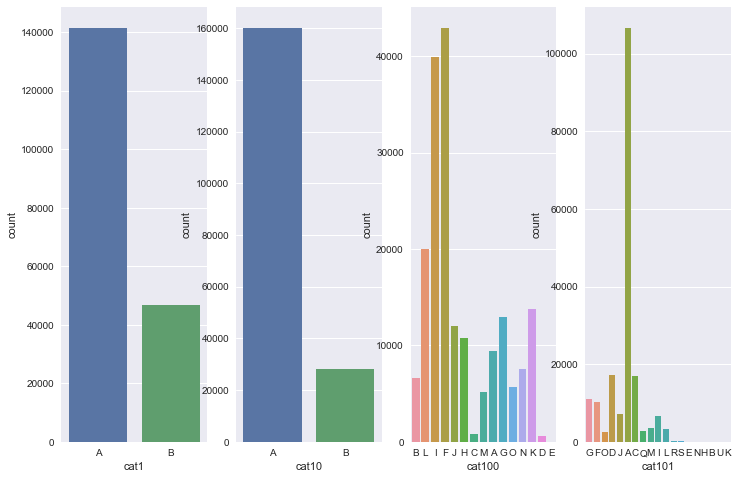

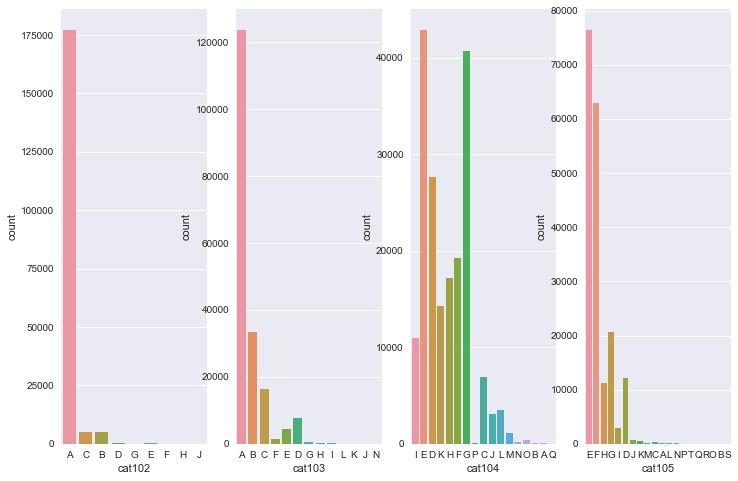

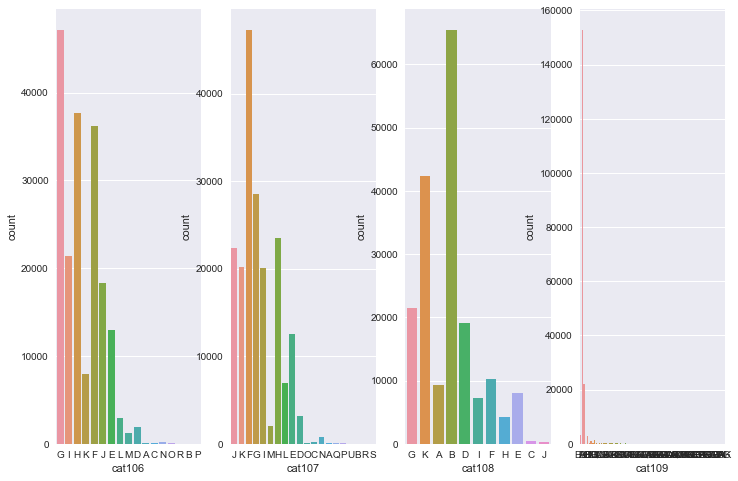

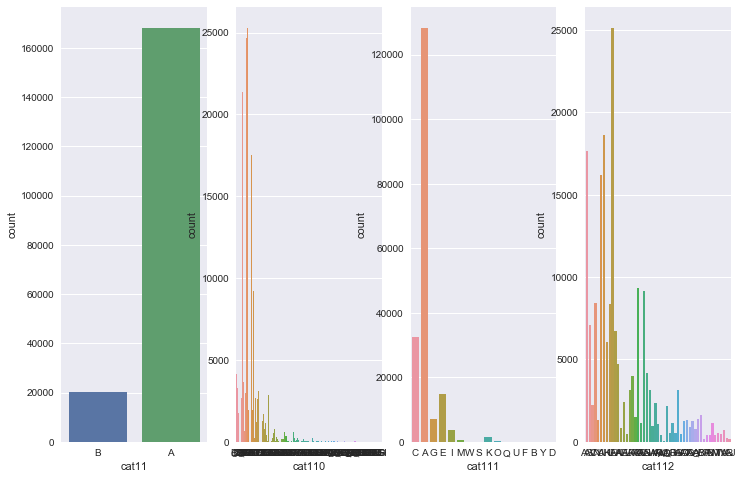

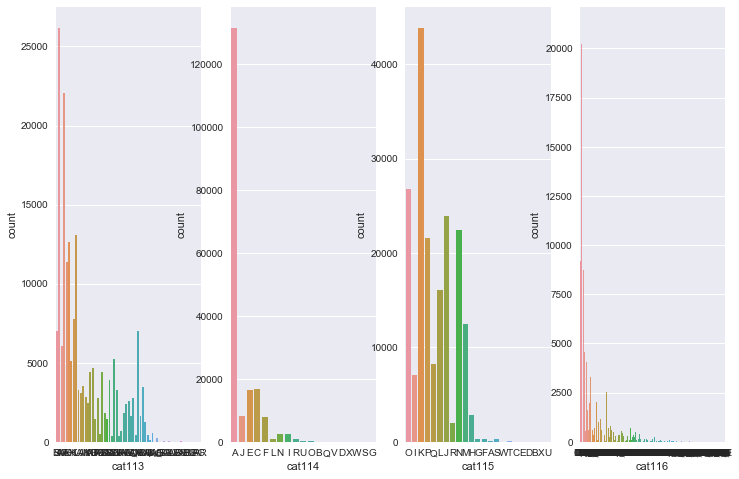

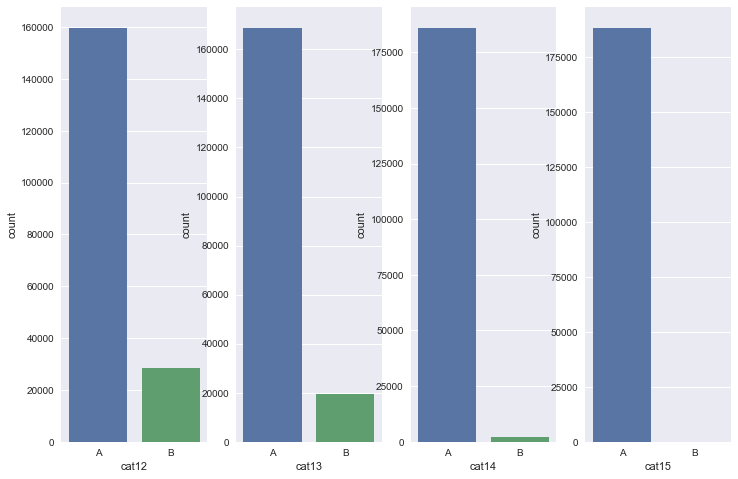

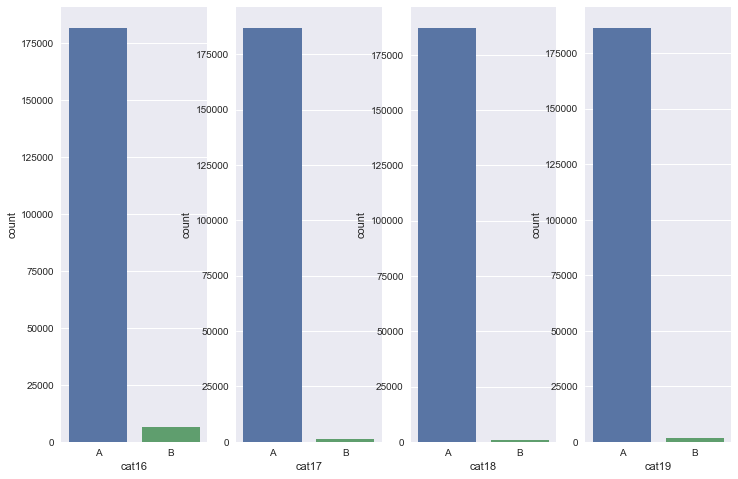

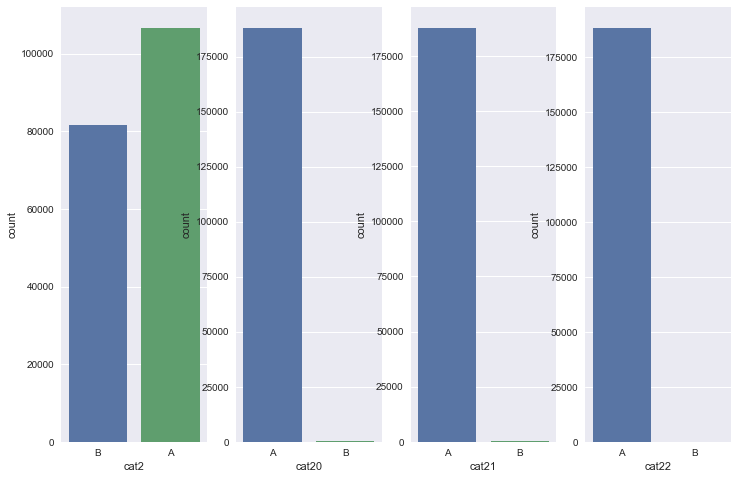

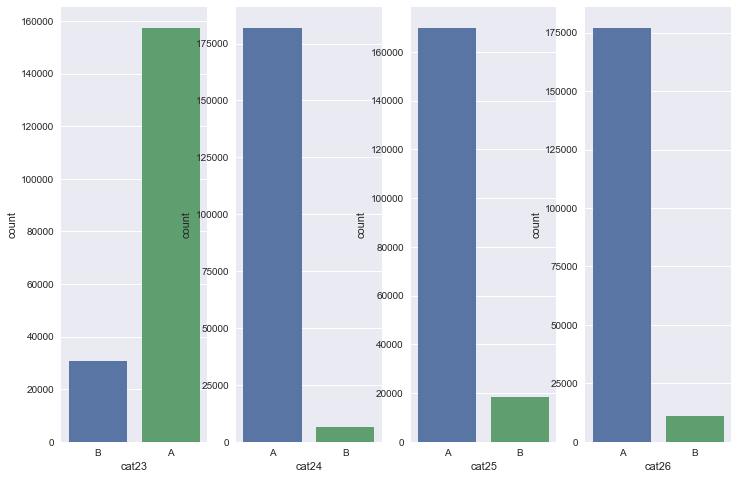

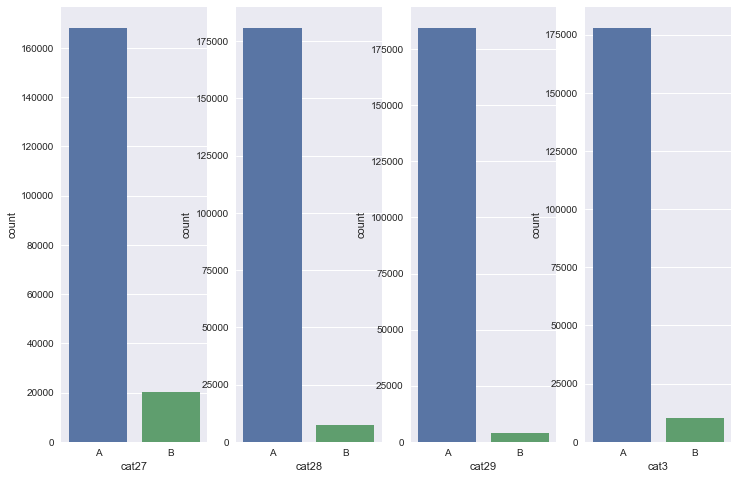

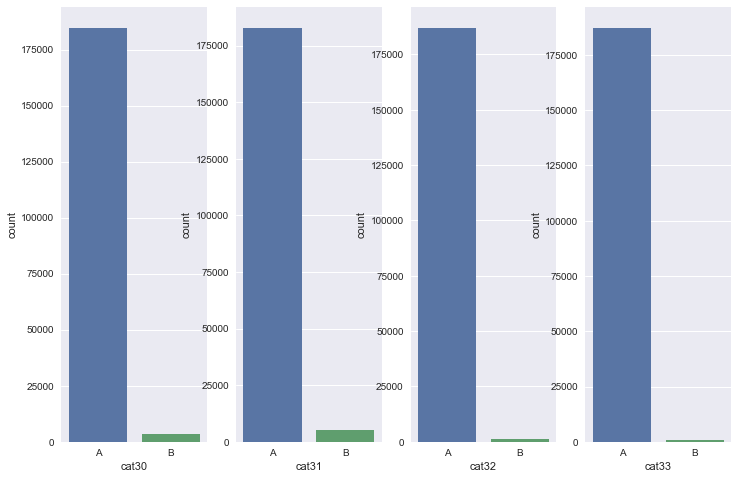

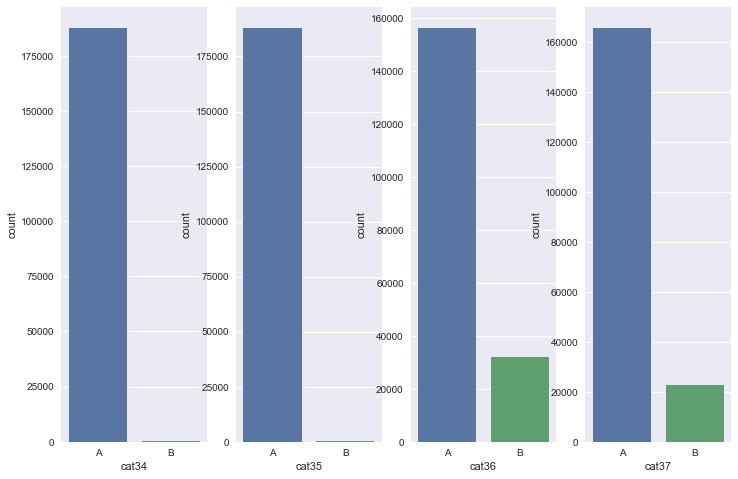

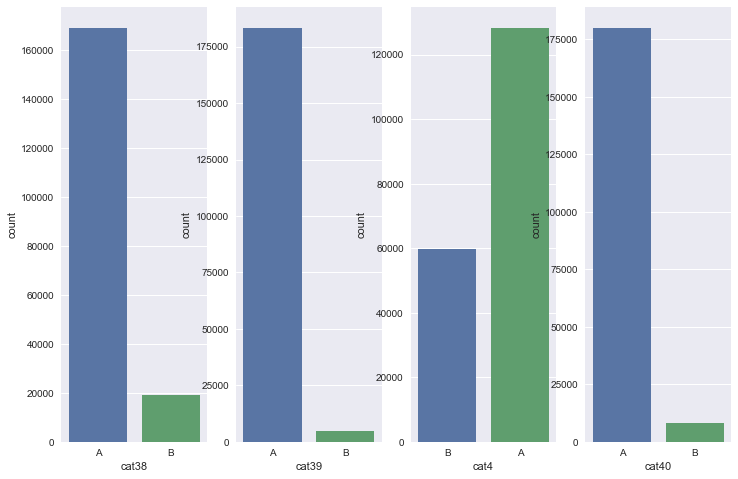

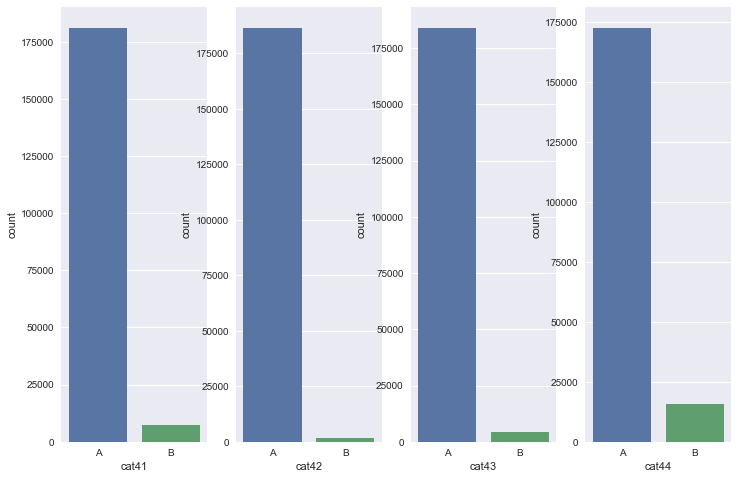

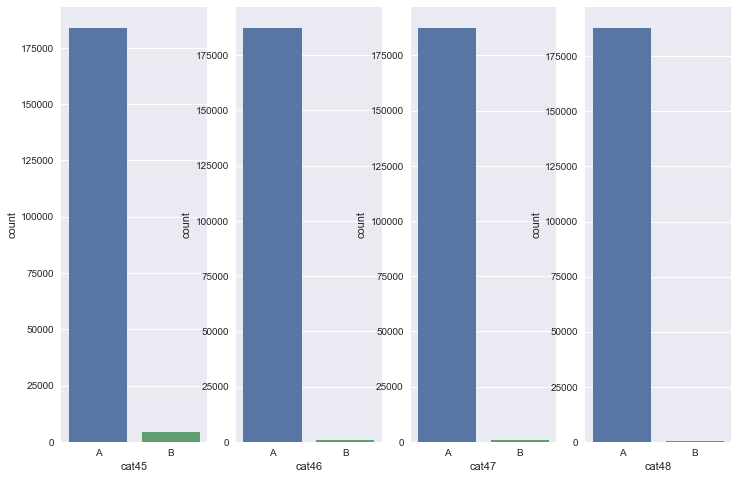

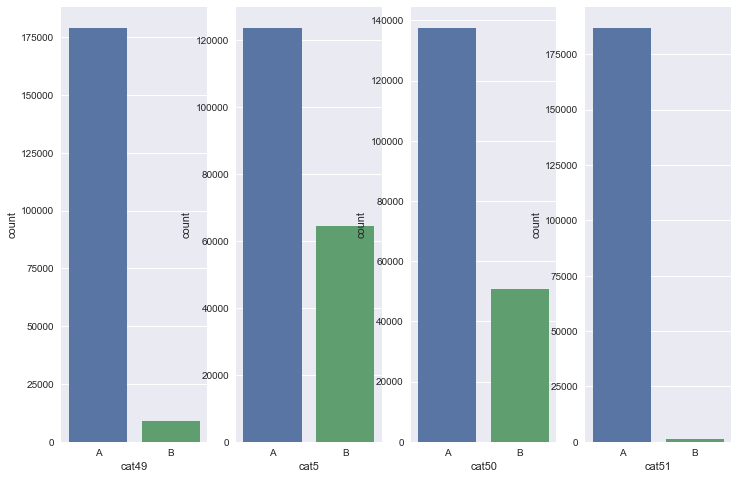

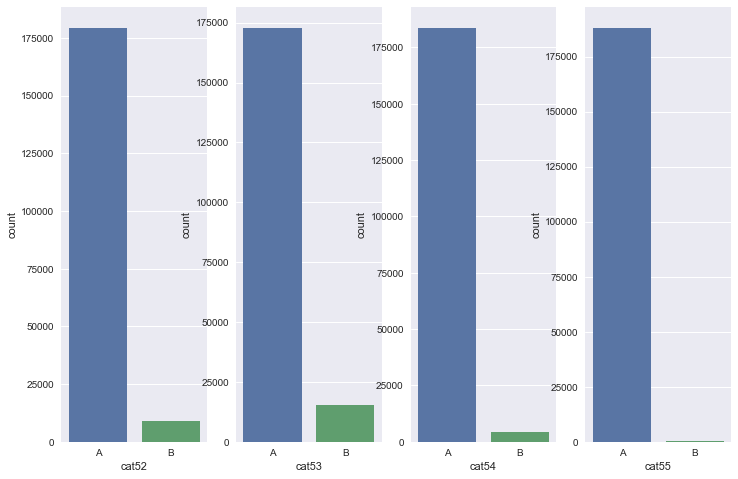

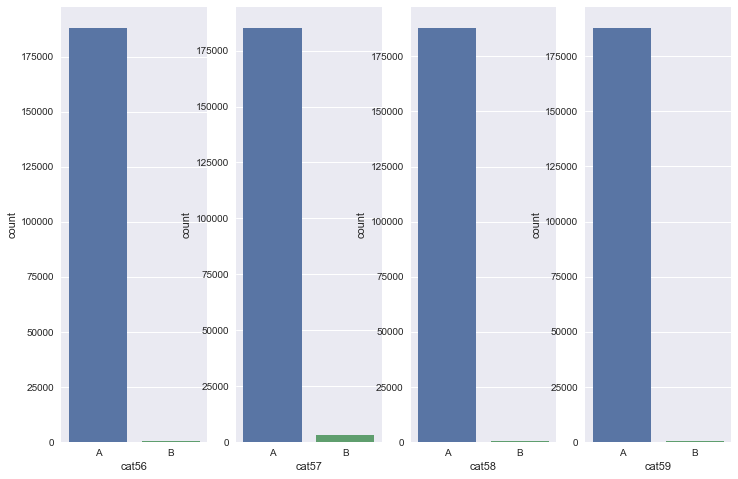

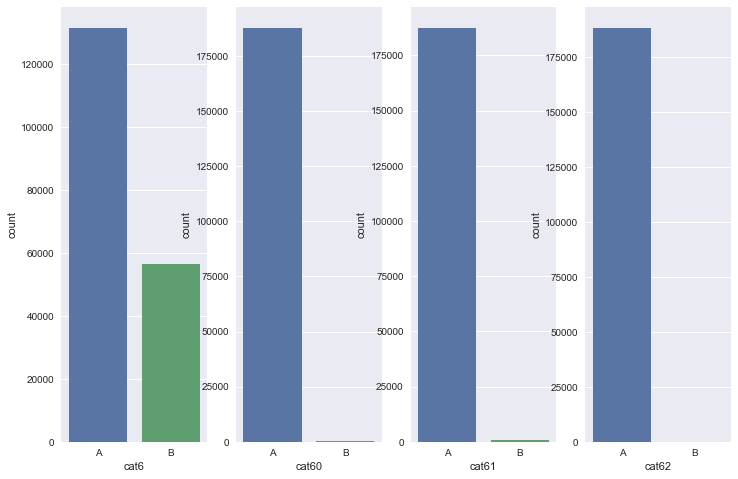

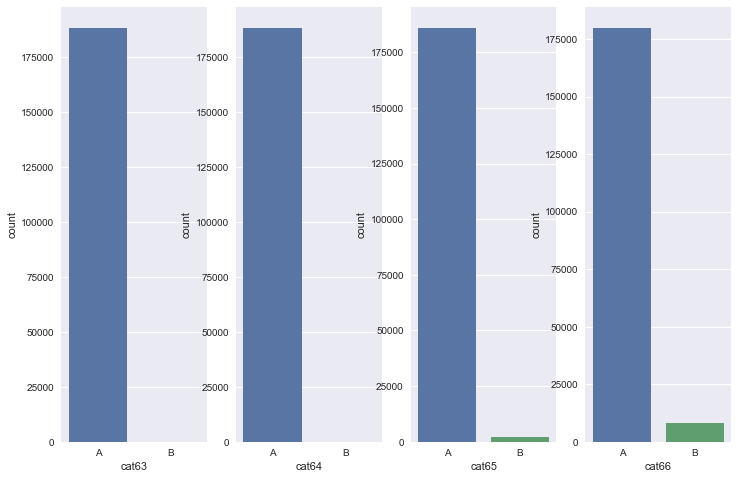

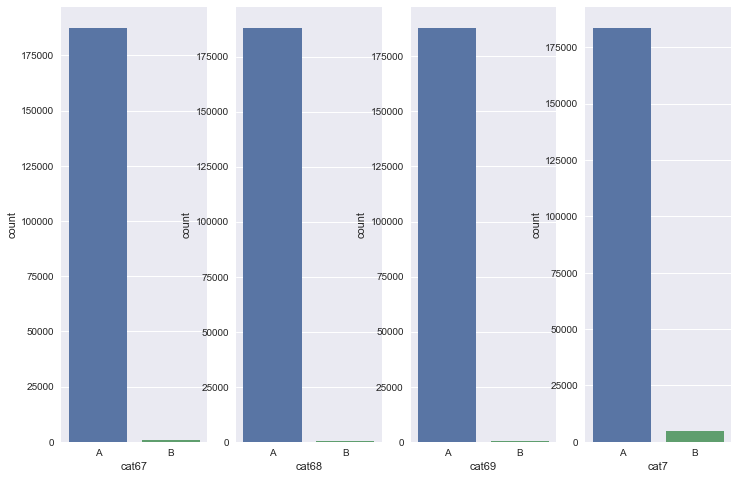

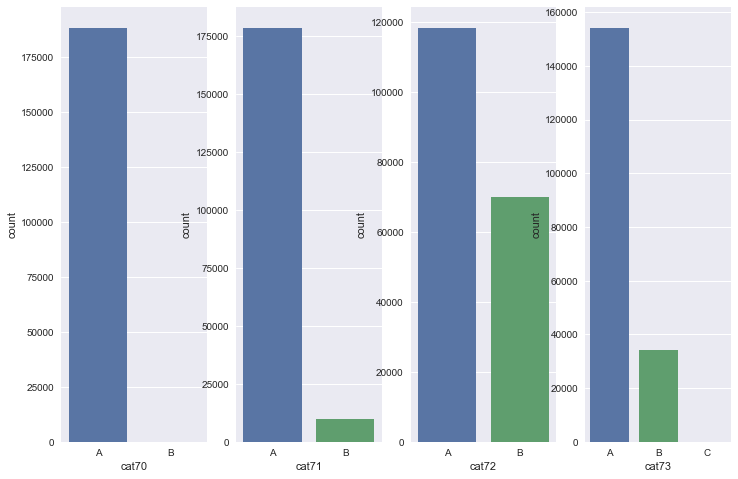

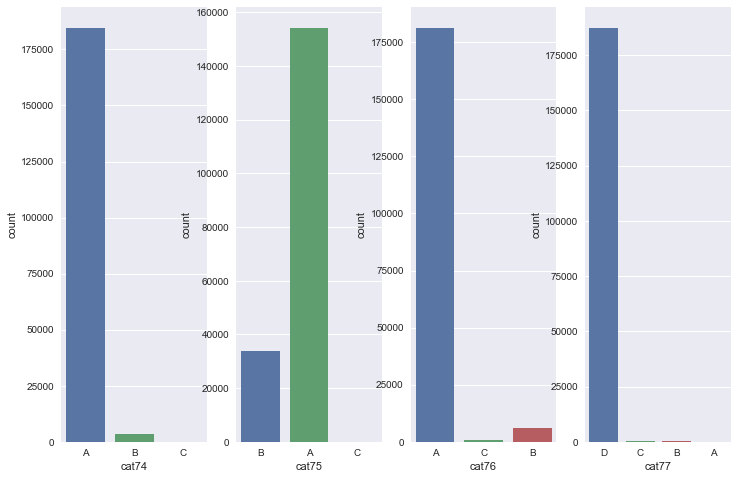

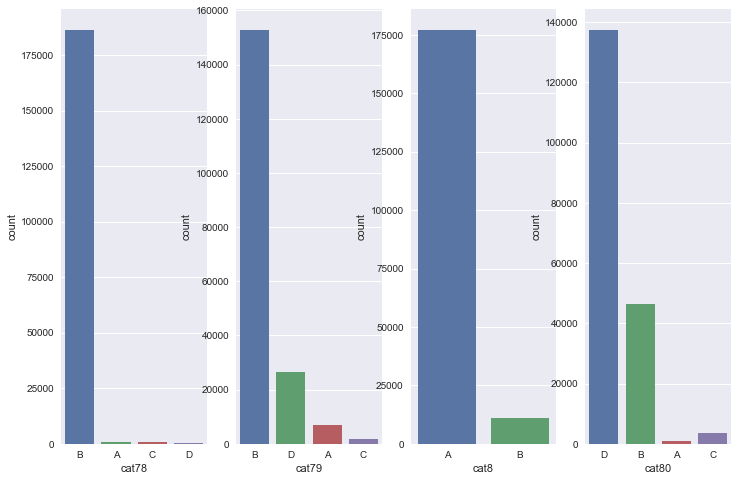

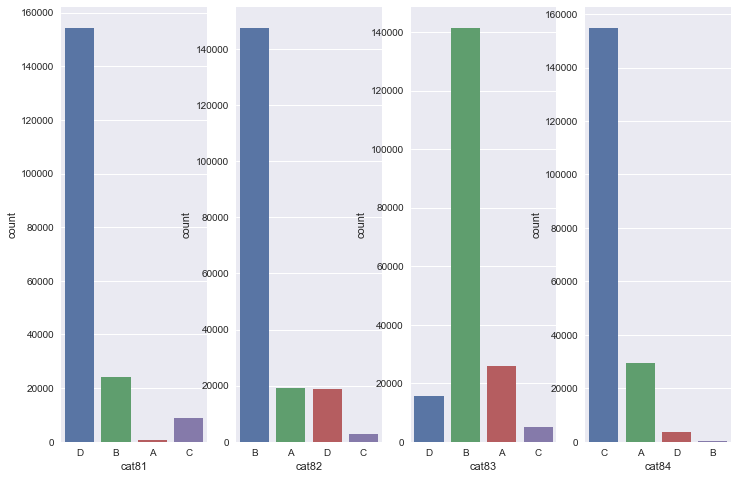

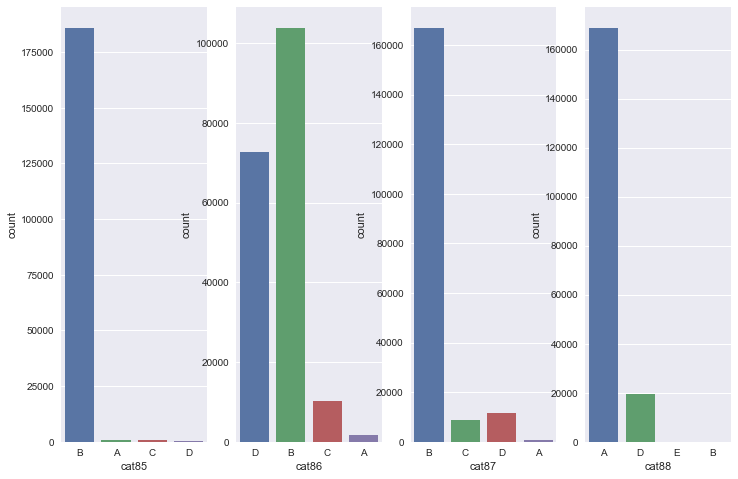

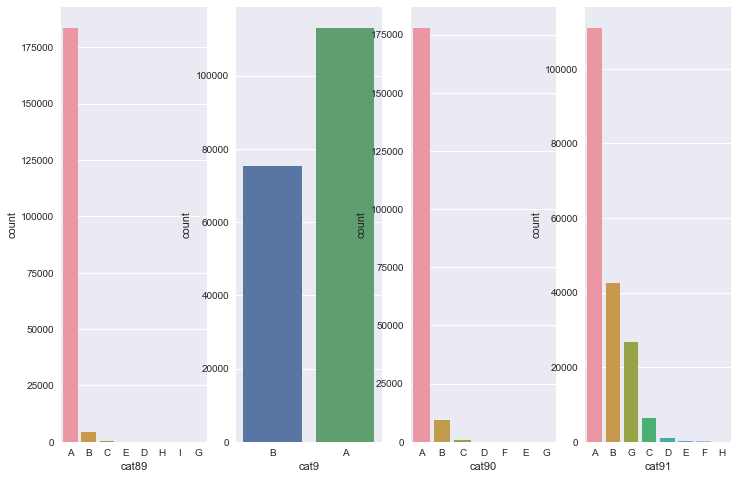

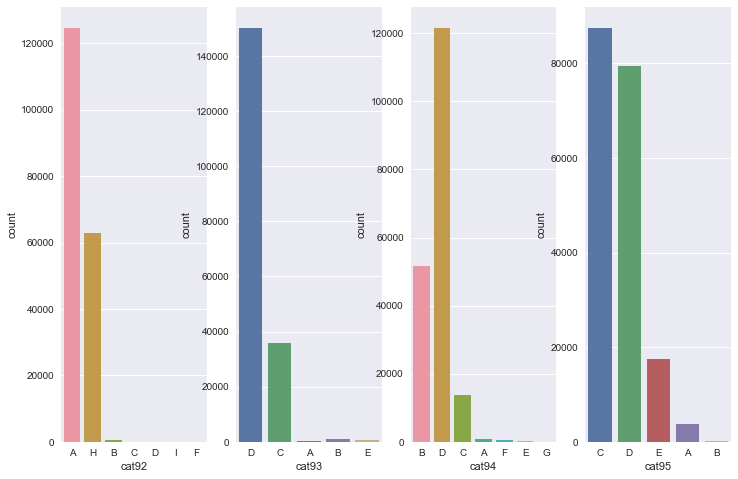

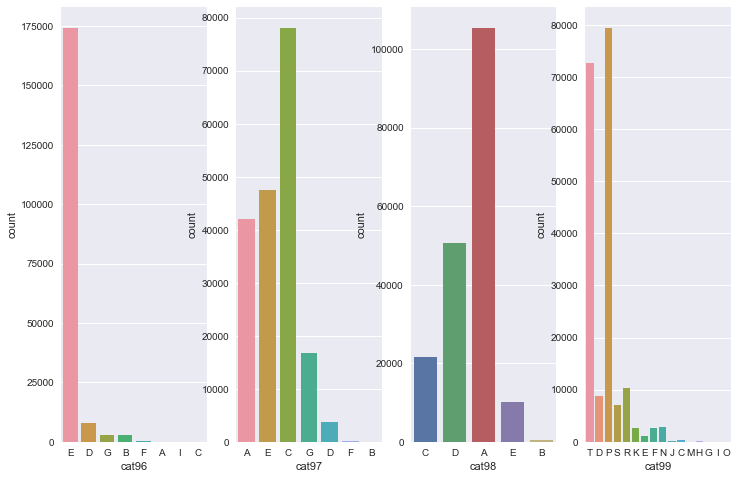

In [33]:
#Plot count plot for all attributes in a 29x4 grid
n_cols = 4
n_rows = 29
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 8))
    for j in range(n_cols):
        sns.countplot(x=cat_cols[i*n_cols+j], data=train, ax=ax[j])

#cat1 to cat72 have only two labels A and B. In most of the cases, B has very few entries
#cat73 to cat 108 have more than two labels
#cat109 to cat116 have many labels

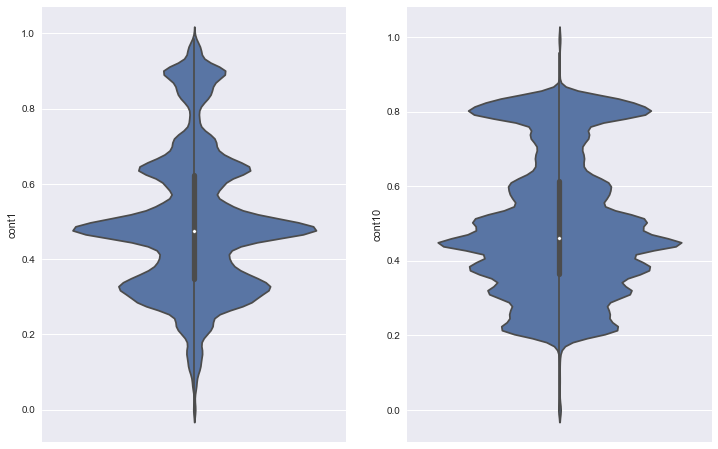

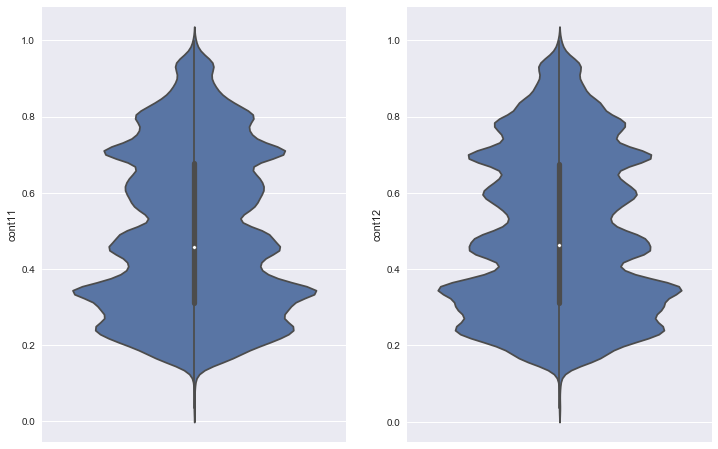

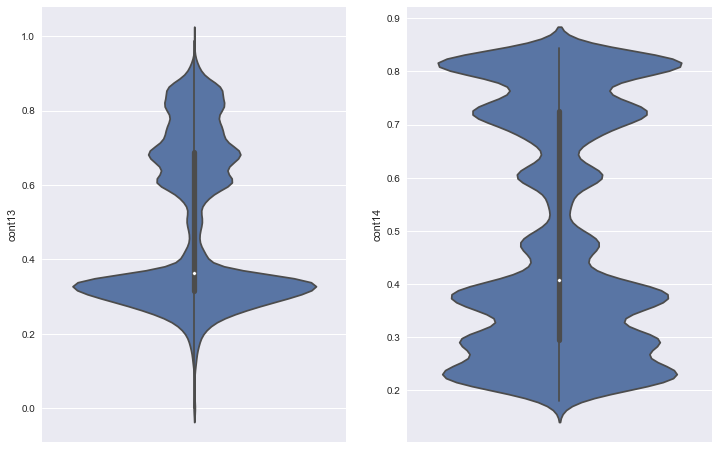

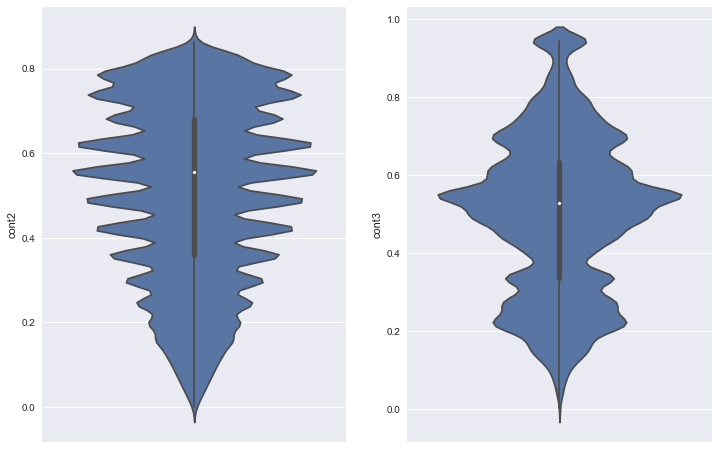

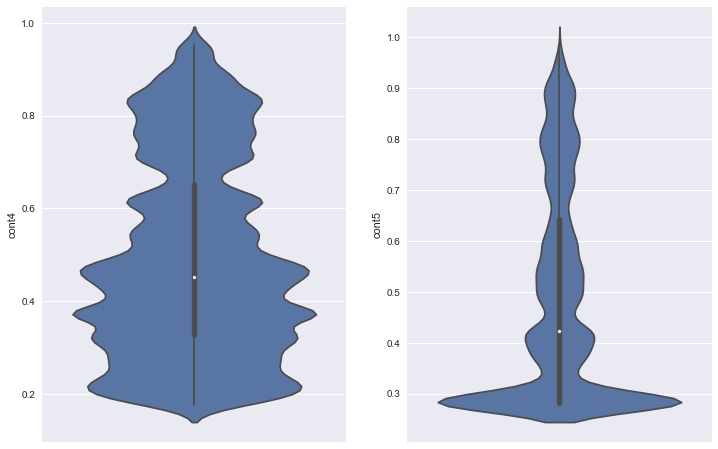

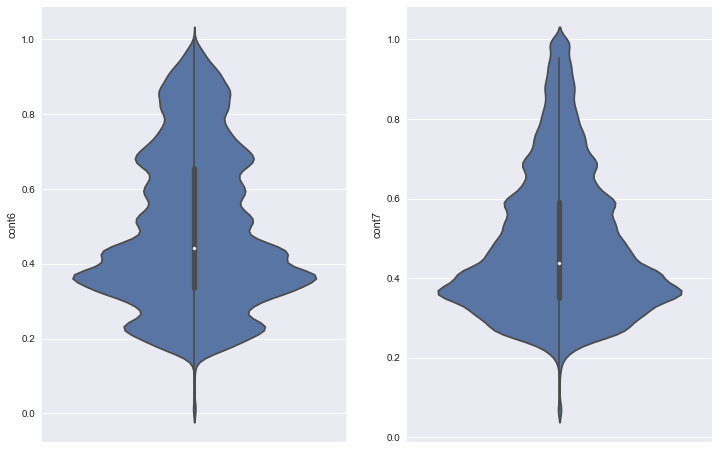

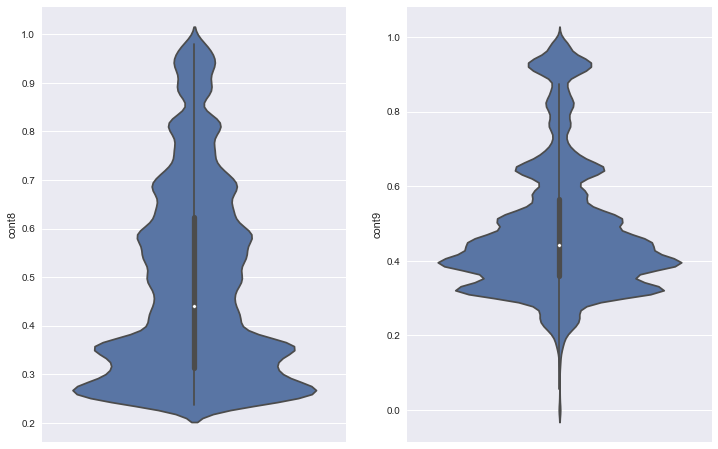

In [37]:
# Plot violin for all attributes in a 7x2 grid
# violin plot: a combination of box and density plots
n_cols = 2
n_rows = 7

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 8))
    for j in range(n_cols):
        sns.violinplot(y=con_cols[i*n_cols+j], data=train, ax=ax[j])

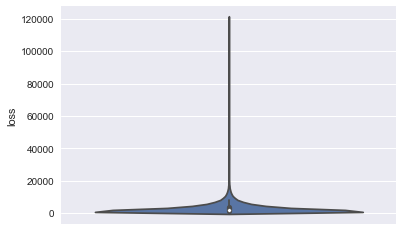

In [38]:
sns.violinplot(data=train,y=train["loss"])
plt.show()

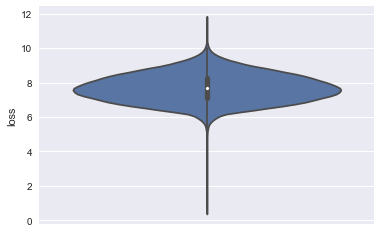

In [39]:
#log1p function applies log(1+x) to all elements of the column
loss = np.log1p(train["loss"])
sns.violinplot(data=train,y=loss)
plt.show()

# Plot shows that skew is corrected to a large extent

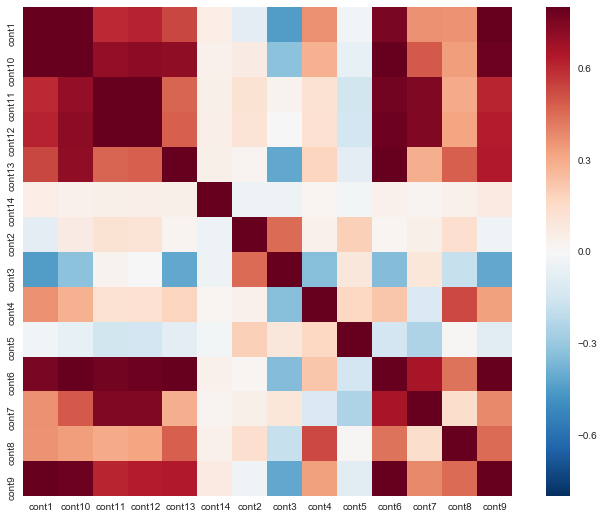

In [43]:
corrmat = train[con_cols].corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))
# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

Strong correlation is observed between several pairs. <br/>
This represents an opportunity to reduce the feature set through transformations such as PCA. <br/>

## Categorical features 
### 1. Label Encoding (Factorizing)

In [47]:
LBL = preprocessing.LabelEncoder()
start=time.time()
LE_map=dict()
for cat_col in cat_cols:
    full_data[cat_col] = LBL.fit_transform(full_data[cat_col])
    LE_map[cat_col]=dict(zip(LBL.classes_, LBL.transform(LBL.classes_)))
print ('Label enconding finished in %f seconds' % (time.time()-start))

Label enconding finished in 35.314588 seconds


In [48]:
LE_map

{'cat1': {'A': 0, 'B': 1},
 'cat10': {'A': 0, 'B': 1},
 'cat100': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'J': 9,
  'K': 10,
  'L': 11,
  'M': 12,
  'N': 13,
  'O': 14},
 'cat101': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'J': 9,
  'K': 10,
  'L': 11,
  'M': 12,
  'N': 13,
  'O': 14,
  'Q': 15,
  'R': 16,
  'S': 17,
  'U': 18},
 'cat102': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'J': 8},
 'cat103': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'J': 9,
  'K': 10,
  'L': 11,
  'M': 12,
  'N': 13},
 'cat104': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'J': 9,
  'K': 10,
  'L': 11,
  'M': 12,
  'N': 13,
  'O': 14,
  'P': 15,
  'Q': 16},
 'cat105': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'J': 9,
  'K': 10,
  'L

### 2. One Hot Encoding (get dummies)

OHE can be done by either Pandas' get_dummies() or SK Learn's OneHotEncoder. 

* get_dummies is easier to implement (can be used directly on raw categorical features, i.e. strings), but it takes longer time and is not memory efficient.

* OneHotEncoder requires the features being converted to numeric, which has already been done by LabelEncoder in previous step, and is much more efficient (7x faster).

* We will convert the OHE's results to a sparse matrix which uses way less memory as compared to dense matrix. However, not all algorithms and packagers support sparse matrix, e.g. Keras. In that case, we'll need to use other tricks to make it work.

* Label encoding introduce in the ordinal to categorical data which does not make sense. And One Hot Encoding creates binary results therefore avoid the problem. But it takes too much space so we could create a sparse matrixs.

In [49]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
full_data_sparse=OHE.fit_transform(full_data[cat_cols])
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))

print (full_data_sparse.shape)

One-hot-encoding finished in 13.387896 seconds
(313864, 1176)


In [ ]:
## one hot coding可以直接对string操作吗 还是需要先变成数值

## Numeric features

We will apply two preprocessings on numeric features:

1. Apply box-cox transformations for skewed numeric features.

2. Scale numeric features so they will fall in the range between 0 and 1.

Please be advised that these preprocessings are not necessary for tree-based models, e.g. XGBoost. However, linear or linear-based models may benefit from them.

** Calculate skewness of each numeric features: **

In [50]:
from scipy.stats import skew, boxcox
skewed_cols = full_data[con_cols].apply(lambda x: skew(x.dropna()))
print (skewed_cols.sort_values())

cont2    -0.311146
cont3    -0.007023
cont14    0.250673
cont11    0.281139
cont12    0.291997
cont10    0.352116
cont13    0.376138
cont4     0.417559
cont6     0.458413
cont1     0.513205
cont8     0.673237
cont5     0.679610
cont7     0.825889
cont9     1.067247
dtype: float64


** Apply box-cox transformations: **<br/>
https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.boxcox.html

In [51]:
skewed_cols = skewed_cols[abs(skewed_cols) > 0.25].index.values
for skewed_col in skewed_cols:
    full_data[skewed_col], lam = boxcox(full_data[skewed_col] + 1)

In [ ]:
## boxcox(full_data[skewed_col]+1)中，为什么‘＋1“？
## 老师，这个和boxcox输入值必须为正数有关吗？
## normalization 和box-cox transformation中只做一个可以吗

** Apply Standard Scaling:**<br/>
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [59]:
SSL = preprocessing.StandardScaler()
for con_col in con_cols:
     full_data[con_col] = SSL.fit_transform(full_data[con_col].values.reshape(-1,1))

In [ ]:
## normalization 是对所有的numerical features,box-cox只是对y 对嘛？

## Model Building: Xgboost

The Xgboost API:<br/>
http://xgboost.readthedocs.io/en/latest/python/python_api.html<br/>
https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

More information for xgboost parameters:<br/>
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [64]:
from scipy import sparse
full_data_sparse = sparse.hstack((full_data_sparse,full_data[con_cols]), format='csr')
print (full_data_sparse.shape)

About sparse matrix:<br/>
https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29

In [71]:
train_x = full_data_sparse[:train_size]
test_x = full_data_sparse[train_size:]
train_y = np.log(full_data[:train_size].loss.values + 200) # since we did log transformation on y-labels
ID = full_data.id[:train_size].values

Here is another experience tip:<br/>
When the problem is regression problem and the evaluation metrics is mse/mae, use the following metrics will get a better result.

In [68]:
def logregobj(labels, preds):
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

def log_mae(y,yhat):
    return mean_absolute_error(np.exp(y), np.exp(yhat))

log_mae_scorer = metrics.make_scorer(log_mae, greater_is_better = False)

In [ ]:
## log_mae 和 log transform y是不是有关

In [78]:
def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = log_mae_scorer,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    return model

In [79]:
param_grid = {'objective':[logregobj],
              'learning_rate':[0.02],
              'n_estimators':[1500],
              'max_depth': [9],
              'min_child_weight':[50],
              'subsample': [0.78],
              'colsample_bytree':[0.67],
              'gamma':[0.9],
              'nthread': [-1],
              'seed' : [1234]}

model = search_model(train_x,
                     train_y,
                     xgb.XGBRegressor(),
                     param_grid,
                     n_jobs = 1,
                     cv = 4,
                     refit = True)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV] seed=1234, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x115acc6a8>, subsample=0.78, colsample_bytree=0.67, max_depth=9, min_child_weight=50, learning_rate=0.02, gamma=0.9 
[CV]  seed=1234, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x115acc6a8>, subsample=0.78, colsample_bytree=0.67, max_depth=9, min_child_weight=50, learning_rate=0.02, gamma=0.9, score=-1135.573586, total=30.2min
[CV] seed=1234, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x115acc6a8>, subsample=0.78, colsample_bytree=0.67, max_depth=9, min_child_weight=50, learning_rate=0.02, gamma=0.9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 30.9min remaining:    0.0s


[CV]  seed=1234, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x115acc6a8>, subsample=0.78, colsample_bytree=0.67, max_depth=9, min_child_weight=50, learning_rate=0.02, gamma=0.9, score=-1139.255827, total=34.2min
[CV] seed=1234, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x115acc6a8>, subsample=0.78, colsample_bytree=0.67, max_depth=9, min_child_weight=50, learning_rate=0.02, gamma=0.9 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 65.8min remaining:    0.0s


KeyboardInterrupt: 

In [80]:
rgr = xgb.XGBRegressor(seed = 1234, 
                       learning_rate = 0.01, # smaller, better results, more time
                       n_estimators = 1500, # Number of boosted trees to fit.
                       max_depth=9, # the maximum depth of a tree
                       min_child_weight=50,
                       colsample_bytree=0.67, # the fraction of columns to be randomly samples for each tree
                       subsample=0.78, # the fraction of observations to be randomly samples for each tree
                       gamma=0.9, # Minimum loss reduction required to make a further partition on a leaf node of the tree, 
                       # the larger, the more conservative 
                       nthread = -1, # Number of parallel threads used to run xgboost.
                       silent = False # Whether to print messages while running boosting.
                      )
rgr.fit(train_x, train_y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.67,
       gamma=0.9, learning_rate=0.01, max_delta_step=0, max_depth=9,
       min_child_weight=50, missing=None, n_estimators=1500, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=False, subsample=0.78)

In [88]:
pred_y = np.exp(rgr.predict(test_x)) - 200

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = pred_y
results.to_csv("output/sub.csv", index=False)
print ("Submission created.")

Submission created.


Here I submit this sub.csv to Kaggle, and the Public Score is 1121.50666, the ranking is 646/3055, not bad.
There are still some other things you can do to improve this score:)

In [ ]:
## 每次坐linear regression都要自定义一个loss function吗
## features很多，需要用pca吗？
## categorical data 怎么做PCA？
## 老师，kaggle比赛结束提交结果也能有score吗？

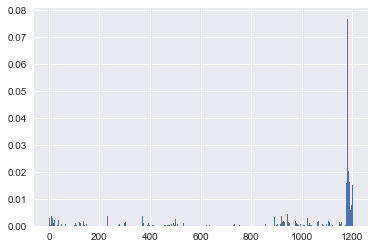

In [133]:
plt.bar(range(len(rgr.feature_importances_)), rgr.feature_importances_)
plt.show()

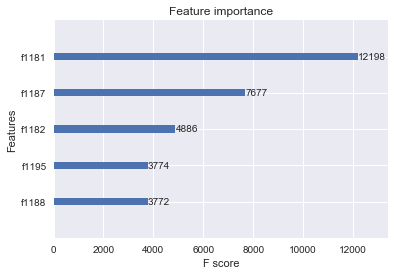

In [150]:
xgb.plot_importance(rgr,max_num_features=5,importance_type='weight')

In [145]:
np.argsort(rgr.feature_importances_)

array([ 601,  620,  621, ..., 1182, 1187, 1181])

You can refer to the following article to see how to select the features according to the feature importance: <br/>
http://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

## Some Feature Combination

Here I will add some new features from the combination of some features.

** Continous Features**

In [89]:
train_test = pd.concat([train,test]).reset_index(drop=True)
## this part create two new features
train_test["cont15"] = train_test["cont1"] + train_test["cont2"] + train_test["cont3"] + train_test["cont4"] + train_test["cont5"] + train_test["cont6"] + train_test["cont7"] + train_test["cont8"] + train_test["cont9"] + train_test["cont10"] + train_test["cont11"] + train_test["cont12"] + train_test["cont13"] + train_test["cont14"]
train_test["cont15"] = train_test["cont15"]/14

train_test["cont16"] = train_test["cont1"] * train_test["cont2"] * train_test["cont3"] * train_test["cont4"] * train_test["cont5"] * train_test["cont6"] * train_test["cont7"] * train_test["cont8"] * train_test["cont9"] * train_test["cont10"] * train_test["cont11"] * train_test["cont12"] * train_test["cont13"] * train_test["cont14"]
train_test["cont16"] = train_test["cont15"]**(1/14)

## this part do the same function with standard scaling and box-cox transformation
train_test["cont1"] = np.sqrt(preprocessing.minmax_scale(train_test["cont1"]))
train_test["cont4"] = np.sqrt(preprocessing.minmax_scale(train_test["cont4"]))
train_test["cont5"] = np.sqrt(preprocessing.minmax_scale(train_test["cont5"]))
train_test["cont8"] = np.sqrt(preprocessing.minmax_scale(train_test["cont8"]))
train_test["cont10"] = np.sqrt(preprocessing.minmax_scale(train_test["cont10"]))
train_test["cont11"] = np.sqrt(preprocessing.minmax_scale(train_test["cont11"]))
train_test["cont12"] = np.sqrt(preprocessing.minmax_scale(train_test["cont12"]))

train_test["cont6"] = np.log(preprocessing.minmax_scale(train_test["cont6"])+0000.1)
train_test["cont7"] = np.log(preprocessing.minmax_scale(train_test["cont7"])+0000.1)
train_test["cont9"] = np.log(preprocessing.minmax_scale(train_test["cont9"])+0000.1)
train_test["cont13"] = np.log(preprocessing.minmax_scale(train_test["cont13"])+0000.1)
train_test["cont14"]=(np.maximum(train_test["cont14"]-0.179722,0)/0.665122)**0.25

In [99]:
skewed_cols_2 = train_test[con_cols].apply(lambda x: skew(x.dropna()))
print (skewed_cols_2.sort_values())

cont14   -0.359569
cont2    -0.311146
cont4    -0.234536
cont6    -0.192447
cont1    -0.137809
cont10   -0.081397
cont11   -0.058008
cont12   -0.051769
cont3    -0.007023
cont5    -0.001885
cont13    0.000933
cont8     0.016604
cont7     0.053462
cont9     0.242141
dtype: float64


** Categorical Features**

In [92]:
COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

In [96]:
import itertools
for comb in itertools.combinations(COMB_FEATURE, 2):
    feat = comb[0] + "_" + comb[1]
    train_test[feat] = train_test[comb[0]] + train_test[comb[1]]
    print('Combining Columns:', feat)

Combining Columns: cat80_cat87
Combining Columns: cat80_cat57
Combining Columns: cat80_cat12
Combining Columns: cat80_cat79
Combining Columns: cat80_cat10
Combining Columns: cat80_cat7
Combining Columns: cat80_cat89
Combining Columns: cat80_cat2
Combining Columns: cat80_cat72
Combining Columns: cat80_cat81
Combining Columns: cat80_cat11
Combining Columns: cat80_cat1
Combining Columns: cat80_cat13
Combining Columns: cat80_cat9
Combining Columns: cat80_cat3
Combining Columns: cat80_cat16
Combining Columns: cat80_cat90
Combining Columns: cat80_cat23
Combining Columns: cat80_cat36
Combining Columns: cat80_cat73
Combining Columns: cat80_cat103
Combining Columns: cat80_cat40
Combining Columns: cat80_cat28
Combining Columns: cat80_cat111
Combining Columns: cat80_cat6
Combining Columns: cat80_cat76
Combining Columns: cat80_cat50
Combining Columns: cat80_cat5
Combining Columns: cat80_cat4
Combining Columns: cat80_cat14
Combining Columns: cat80_cat38
Combining Columns: cat80_cat24
Combining Colu

In [103]:
data_types_2 = train_test.dtypes  
cat_cols_2 = list(data_types_2[data_types_2=='object'].index)

In [111]:
LBL2 = preprocessing.LabelEncoder()
start=time.time()
LE_map2=dict()
for cat_col in cat_cols_2:
    train_test[cat_col] = LBL2.fit_transform(train_test[cat_col])
    LE_map2[cat_col]=dict(zip(LBL2.classes_, LBL2.transform(LBL2.classes_)))
print ('Label enconding finished in %f seconds' % (time.time()-start))

Label enconding finished in 7.941103 seconds


In [113]:
OHE2 = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
train_test_sparse=OHE2.fit_transform(train_test[cat_cols_2])
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))

print (train_test_sparse.shape)

One-hot-encoding finished in 92.251634 seconds
(313864, 7000)


In [ ]:
## Add cont15 and cont16 into the con_cols list
con_cols.append('cont15')
con_cols.append('cont16')

In [118]:
train_test_sparse = sparse.hstack((train_test_sparse,train_test[con_cols]), format='csr')
print (train_test_sparse.shape)

(313864, 7016)


In [128]:
train_x_2 = train_test_sparse[:train_size]
test_x_2 = train_test_sparse[train_size:]
train_y_2 = np.log(train_test[:train_size].loss.values + 200)
ID = train_test.id[:train_size].values

In [129]:
rgr2 = xgb.XGBRegressor(seed = 0, 
                       learning_rate = 0.03, 
                       n_estimators = 1500,
                       max_depth=10,
                       min_child_weight=100,
                       colsample_bytree=0.7,
                       subsample=0.7,
                       gamma=0.9,
                       nthread = -1,
                       silent = 1
                      )
rgr2.fit(train_x_2, train_y_2)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0.9, learning_rate=0.03, max_delta_step=0, max_depth=10,
       min_child_weight=100, missing=None, n_estimators=1500, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.7)

The training time for this model is pretty long, about 3~4 hrs for one-time training.

In [130]:
pred_y_2 = np.exp(rgr2.predict(test_x_2)) - 200

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = pred_y_2
results.to_csv("output/sub2.csv", index=False)
print ("Submission created.")

Submission created.


Here I submit this sub2.csv to Kaggle, and the Public Score is 1113.44349, the ranking is 99/3055.

In [ ]:
## 在kernel和discussion看到的帖子里的code可以拿来自己用吗
## feature 组合 和svm里面的kernel func是不是一个意思， 可以用kernel func在xgboost吗
## 老师，feature combination通常怎么组合呢？组合可能性太多了。。。
## 老师，比赛时允许用别人kernel调出来的参数组合来提交结果吗？
## 做kaggle时，一般要花几天跑程序吗？